# Milestone 4: graph signal processing

[EPFL LTS2](http://lts2.epfl.ch)

## Students

* Team: `<52>`
* Students: `<Reza Hosseini, Jawwad Ahmed, Miguel Gómez, Emmanouil Jacovides>`
* Dataset: `<Free Music Archive dataset>`

## Objective

The goal of this milestone is to do some Graph Signal Processing (GSP) on the data of your project to extract insights about the structure of our network.

## 0 - Loading the network

In [1]:
%matplotlib inline

In [50]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers

from pygsp import graphs, filters, plotting
plt.rcParams['figure.figsize'] = (12, 7)
plotting.BACKEND = 'matplotlib'
import seaborn as sns
sns.set()

In [3]:
from pylab import cm
from matplotlib import colors

# Getting Color pallete for plotting
cmap = cm.get_cmap('Spectral', 7)
color_codes1 = []
color_codes2 = []
color_codes3 = []
for i in range(cmap.N):
    rgb1 = cmap(i)[:3] + (0.5,)
    rgb2 = cmap(i)[:3] + (0.8,)
    rgb3 = cmap(i)[:3] + (0.65,)
    color_codes1.append(rgb1)
    color_codes2.append(rgb2)
    color_codes3.append(rgb3)

For this milestone, all we will need is a set of features/labels for each of the nodes on the network, as well as the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while working on milestone 3.

Import those objects in the cell below (or recompute the Laplacian and Gradient from your stored adjacency matrix, if you wish).

_Note_: If your features/labels are not floating-point numbers, please convert them. For example, if your data has labels "cat" and "dog" for nodes that represent cats or dogs, respectively, you may assign the number `1.0` for the label "cat" and the number `-1.0` for the label "dog".  

In [4]:
# the adjacency matrix
A =  np.load('adjacency.npy') 

In [5]:
def graph_laplacian(A):
    '''
    Calculating laplacian and the diagonal matrix
    '''
    # The rows are summed up to obtain the degree for each of the nodes
    degree = np.array([np.sum(e) for e in A.T])
    #Calculating diagonal matrix
    D = np.diag(degree)
    # Calculating D^(0.5) for normalized laplacian
    D_inv_sqrt = np.linalg.inv(scipy.linalg.sqrtm(D)) 
    # Calculating combinotorial laplacian
    laplacian_combinatorial = np.subtract(D, A)
    # Calculating the laplacian
    laplacian_normalized = D_inv_sqrt @ laplacian_combinatorial @ D_inv_sqrt 
    
    return laplacian_normalized

def adjacency2Incidence(A):
    '''
    Gets adjacency matrix as inputs and
    Returns the Incidence matrix from the adjacency matrix
    '''
    # The rows are summed up to obtain the degree for each of the nodes
    degree = np.array([np.sum(e) for e in A.T])
    #Calculating diagonal matrix
    D = np.diag(degree)
    
    # Getting the indices of upper triangle of the matrix
    A_triu = np.triu(A)
    # Getting pairs of indices for each edges
    x, y = np.where(A_triu!=0)
    
    num_e = x.shape[0] #number of edges
    num_n = A.shape[0] #number of nodes
    
    # Getting the square root of Weights
    W_sq = np.sqrt(A)
    #Initilizing the incidence matrix
    S = np.zeros((num_n, num_e))
    
    # Filling the incidence matrix
    for i, j, k in zip(x,y, range(num_e)):
        S[i,k] = W_sq[i,j]
        S[j,k] = -W_sq[i,j]
    
    # Normalizing the incidence matrix (to get the consistent answer for laplacian)
    S_norm = np.linalg.inv(np.sqrt(D))@S
    
    return S, S_norm

def eigDecompose(laplacian):
    '''
    Compute the sorted eigenvalues and eigenvectors
    '''
    # Computing the eigenvalues and eigenvectors for the normalized Laplacian
    # with scipy.linalg.eig
    eigenvalues, eigenvectors = scipy.linalg.eig(laplacian)

    # Only keeping the real part of eigenvalues
    eigenvalues = np.real(eigenvalues)

    # Sorting the values
    idx = eigenvalues.argsort() 
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    
    return eigenvalues, eigenvectors

In [6]:
laplacian = graph_laplacian(A)
gradient = adjacency2Incidence(A)[1].T
gradient_sparse = sparse.csr_matrix(gradient)
labels = np.r_[np.full((1000,),-1.0),np.full((1000,), 1.0)]
n_nodes = A.shape[0]

In [7]:
#Checking to see if we defined incident matrix correctly
laplacian_S = gradient.T@gradient
if np.allclose(laplacian, laplacian_S):
    print('The calculated Laplacians from Incidence matrix and D-A are the same')
else:
    print('The calculated Laplacians from Incidence matrix and D-A are not the same')

The calculated Laplacians from Incidence matrix and D-A are the same


## 1 - Graph Fourier Transform

In this section we will observe how your feature/label vector looks like in the "Graph Fourier" domain.

### Question 1

Compute the Fourier basis vectors and the Laplacian eigenvalues. Make sure to order those from smaller to larger, $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1},$ and use the same ordering for the Fourier basis vectors.

In [8]:
e, U = eigDecompose(laplacian)

Plot the first 3 and the last Fourier basis vectors as signals on your graph. Clearly indicate which plot belongs to which basis vector.

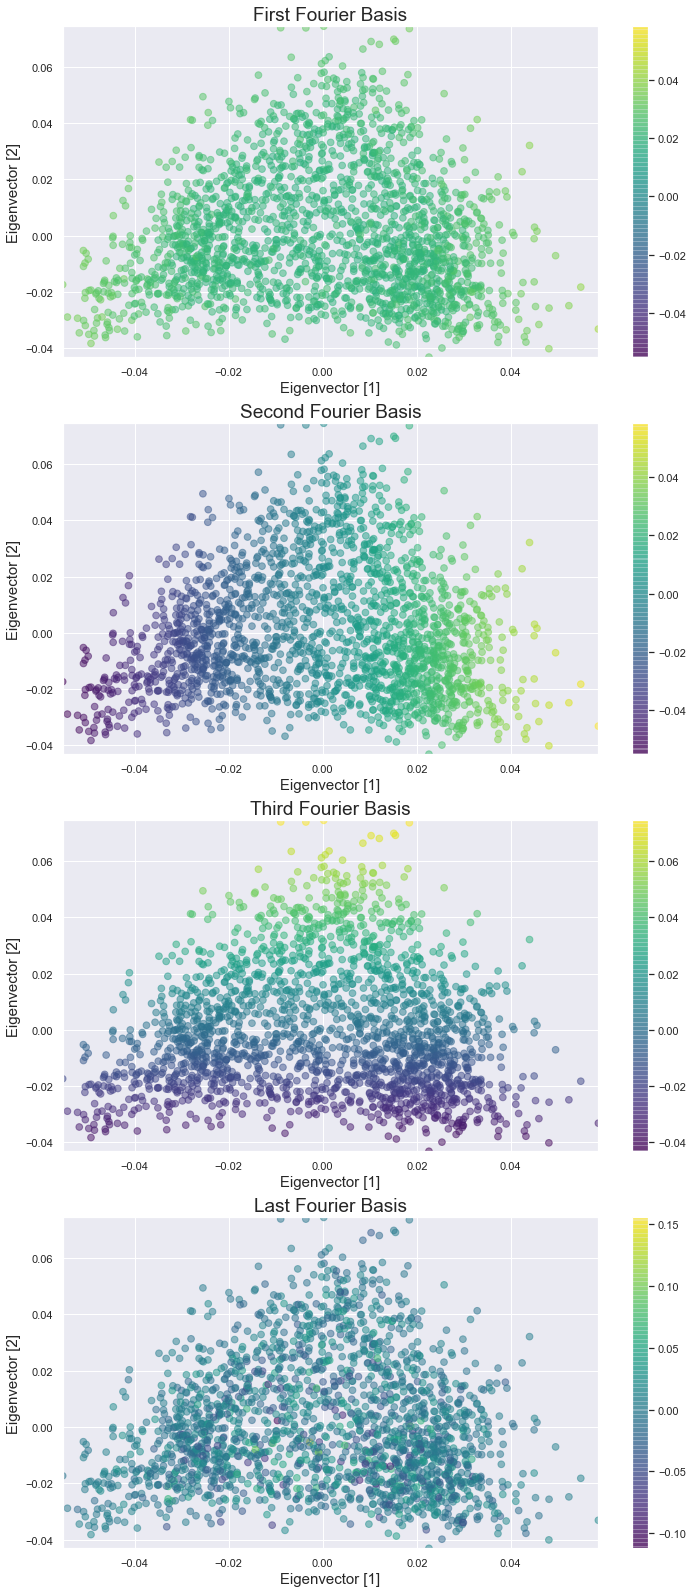

In [9]:
x = U[:,1]
y = U[:,2]
fig,ax=plt.subplots(4,1,figsize=(12,28))

# First Fourier Basis
p_ax0 = ax[0].scatter(x, y, c=U[:,0], cmap='viridis', s=45, alpha=0.5, vmin=np.min(U[:,1]), vmax=np.max(U[:,1]))
ax[0].set_ylim([np.min(y),np.max(y)])
ax[0].set_xlim([np.min(x),np.max(x)])
ax[0].set_title('First Fourier Basis', fontsize=19)
ax[0].set_xlabel('Eigenvector [1]', fontsize=15)
ax[0].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax0, ax=ax[0])

# Second Fourier Basis
p_ax1 = ax[1].scatter(x, y, c=U[:,1], cmap='viridis', s=45, alpha=0.5, vmin=np.min(U[:,1]), vmax=np.max(U[:,1]))
ax[1].set_ylim([np.min(y),np.max(y)])
ax[1].set_xlim([np.min(x),np.max(x)])
ax[1].set_title('Second Fourier Basis', fontsize=19)
ax[1].set_xlabel('Eigenvector [1]', fontsize=15)
ax[1].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax1, ax=ax[1])
# Third Fourier Basis
p_ax2 = ax[2].scatter(x, y, c=U[:,2], cmap='viridis', s=45, alpha=0.5, vmin=np.min(U[:,2]), vmax=np.max(U[:,2]))
ax[2].set_ylim([np.min(y),np.max(y)])
ax[2].set_xlim([np.min(x),np.max(x)])
ax[2].set_title('Third Fourier Basis', fontsize=19)
ax[2].set_xlabel('Eigenvector [1]', fontsize=15)
ax[2].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax2, ax=ax[2])

# Last Fourier Basis
p_ax3 = ax[3].scatter(x, y, c=U[:,-1], cmap='viridis', s=45, alpha=0.5, vmin=np.min(U[:,-1]), vmax=np.max(U[:,-1]))
ax[3].set_ylim([np.min(y),np.max(y)])
ax[3].set_xlim([np.min(x),np.max(x)])
ax[3].set_title('Last Fourier Basis', fontsize=19)
ax[3].set_xlabel('Eigenvector [1]', fontsize=15)
ax[3].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax3, ax=ax[3])
plt.show()

### Question 2

What can you observe in terms of local variations when comparing the basis vectors corresponding to the smallest eigenvalues to those corresponding to the largest eigenvalue? How would this justify the interpretation of the eigenvalues as "graph frequencies"?

**Answer:**

From the plots, we can see that the first fourier basis is almost constant. The second fourier basis has a very smooth variation over the nodes, and the third fourier basis has slightly larger variation and it's orthogonal to the first two fourier basis. And as we go the higher eigenvalues, the variation becomes more intense.

This is consistent with the notion of fourier, where we have higher frequency for higher fourier basis. In fact, we can see the eigenvalues as frequencies in Fourier domain.

### Question 3

Implement a function that returns the Graph Fourier Transform (GFT) of a given vector $x \in \mathbb{R}^{N},$ with respect to your graph, and a function that computes the corresponding inverse GFT (iGFT).

In [10]:
def GFT(x):
    return U.T@x

def iGFT(x):
    return U@x

### Question 4

Plot your feature/label vector as a signal on your graph

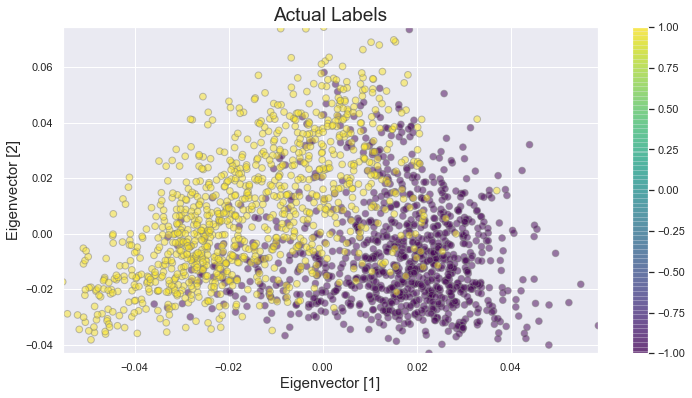

In [11]:
x = U[:,1]
y = U[:,2]
fig,ax=plt.subplots(1,1,figsize=(12,6))

# First Fourier Basis
p_ax = ax.scatter(x, y, c=labels, edgecolors='gray', cmap='viridis', s=45, alpha=0.5, vmin=np.min(labels), vmax=np.max(labels))
ax.set_ylim([np.min(y),np.max(y)])
ax.set_xlim([np.min(x),np.max(x)])
ax.set_title('Actual Labels', fontsize=19)
ax.set_xlabel('Eigenvector [1]', fontsize=15)
ax.set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax, ax=ax)
plt.show()

Plot the absolute values of the GFT of your feature/label signal as a function of the graph eigenvalues. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.

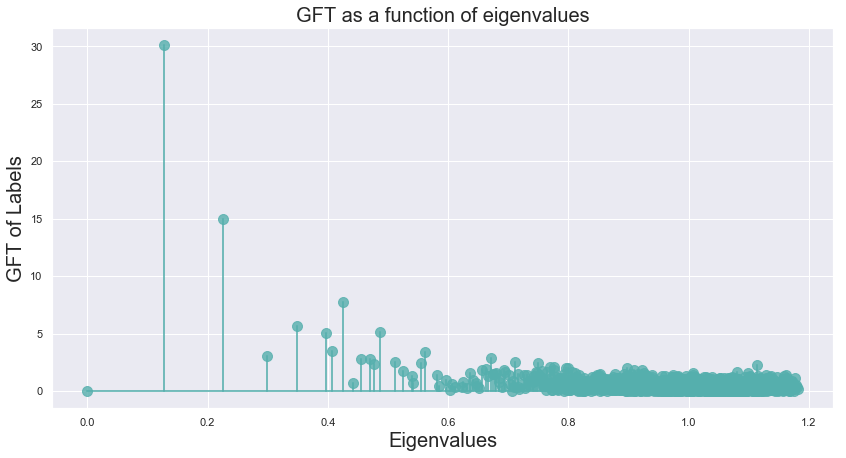

In [12]:
fig, ax = plt.subplots(1,1, figsize=(14,7))

# Plotting Stem-plot
markers,stems,base = ax.stem(e, np.abs(GFT(labels)), label='Heat Kernel Filter on Signal')
plt.setp(markers, markersize=10, color=color_codes2[5])
plt.setp(base, color=color_codes2[5], linewidth=2)
plt.setp(stems, color=color_codes2[5], linewidth=2)
plt.ylabel('GFT of Labels', fontsize=20)
plt.xlabel('Eigenvalues', fontsize=20)
plt.title('GFT as a function of eigenvalues', fontsize=20)
plt.show()

### Question 5

Discuss the behavior of the GFT that you plotted in the last question via comparing the plot of your label signal and those of the Fourier basis of Question 1. Would you consider your labels a "low-pass" or "high-pass" signal, or yet something else entirely?

**Answer:**
From the comparison between our Actual Labels plot and the Fourier Basis plots, it can be seen that when we have lower eigenvalues, there are more smooth variations of the nodes. As we go towards higher eigenvalues, higher variations can be observed since it corresponds to a higher Fourier Basis. This notion of higher variations as the eigenvalue increases is the principle of Fourier. As our network has two clear clusters (Hip-hop and Rock), the lower eigenvalues capture better this information of our network.

Thus, we will consider our labels a "Low-pass" signal as the lower eigenvalues plots correspond better to the real labels plot.

## 2 - Filtering on graphs

In this section we will check how filtered Dirac impulses diffuse on your graph.

### Question 6 

Implement the following three filter kernels and the graph filtering operation.

- The **heat kernel** is supposed to take in a vector of eigenvalues `e` and a parameter `t` and output a vector of evaluations of the heat kernel at those eigenvalues (see the course slides for help).
- The **inverse filter** kernel is supposed to take in a vector of eigenvalues `e` and a parameter `t` and implement spectrally the  filter defined in the node domain by $f_{out}  = (I + t L)^{-1} f_{in},$ where $f_{in}, f_{out} \in \mathbb{R}^{N}$ are, repectively, the input and output signals to the filter.
- The **rectangle kernel** takes in a vector of eigenvalues `e` and parameters `l_min` and `l_max` and returns `1.0` at coordinates satisfying $(e[l] \geq l_{min}) \wedge (e[l] \leq l_{max}),$ and `0.0` otherwise.
- The **graph filtering** operation takes a graph signal $x \in \mathbb{R}^{N}$, a spectral graph `kernel` and a set of keyworded variables, and returns the corresponding filtered signal.
    - _Hint:_ Remember that you have implemented the `GFT` and `iGFT` operations in Question 3.
    - The `**kwargs` is a placeholder to collect supplementary pairs of keyword-values that are not known by the implementation before execution time.
      The `kwargs` variable is a dictionary whose keyes and values are the parameter names and values.
      This is useful to allow both `graph_filter(x, heat_kernel, tau=1.0)` and `graph_filter(x, rectangle_kernel, lambda_min=0.0, lambda_max=1.0)` to be valid calls from the same implementation.
      One can then defer the keyword-value assignment to the `kernel` call: `foo = kernel(bar, **kwargs)`.

In [13]:
def heat_kernel(e, t):
    return np.diag(np.exp(-t*e/e.max()))

def inverse_kernel(e, t):
    return np.linalg.inv(np.eye(e.shape[0])+t*np.diag(e))

def rectangle_kernel(e, l_min, l_max):
    return np.diag(np.ones((e.shape[0],))*((e>l_min)&(e<l_max)))

def graph_filter(x, kernel, **kwargs):
    if kernel=='rectangle_kernel':
        y = iGFT(rectangle_kernel(e, l_min=kwargs['lambda_min'], l_max=kwargs['lambda_max'])@GFT(x))
    elif kernel=='heat_kernel':
        y = iGFT(heat_kernel(e, t=kwargs['tau'])@GFT(x))
    elif kernel=='inverse_kernel':
        y = iGFT(inverse_kernel(e, t=kwargs['tau'])@GFT(x))
    else:
        raise KeyError('"kernel" parameter can only get "rectangle_kernel", "heat_kernel", and "inverse_kernel" strings as a value!')
    
    return y

### Question 7

Plot all three filter kernels in the spectral domain. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).

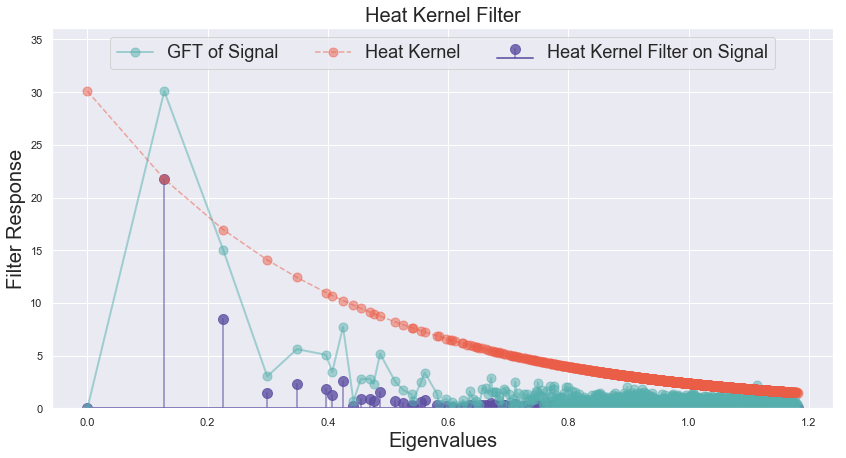

In [14]:
# Heat Kernel
# Computing Graph Fourier Transform
sns.set()
GFT_x = GFT(labels)

# Computing Heat Kernel response on Signal
tau= 3.0
HK = heat_kernel(e, t=tau)@GFT_x

# Computing Heat Kernel plot alone
HK_p = heat_kernel(e, t=tau)@np.full((2000,), np.abs(GFT_x).max())

fig, ax = plt.subplots(1,1, figsize=(14,7))

# Plotting Stem-plot for Heat Kernel Response on Signal
markers,stems,base = ax.stem(e, np.abs(HK), label='Heat Kernel Filter on Signal')
plt.setp(markers, markersize=10, color=color_codes2[6])
plt.setp(base, color=color_codes2[6], linewidth=2)
plt.setp(stems, color=color_codes1[6], linewidth=2)

#Plotting GFT of Signal for comparison
ax.plot(e, np.abs(GFT_x), color=color_codes1[5], linewidth=2, marker='o', markersize=9, label='GFT of Signal')

#Plotting Heat Kernel Alone
ax.plot(e, np.abs(HK_p), color=color_codes1[1], linestyle='--', marker='o', markersize=9,
        label='Heat Kernel')

#Setting Properties of plot
ax.set_ylabel('Filter Response', fontsize=20)
ax.set_xlabel('Eigenvalues', fontsize=20)
ax.set_title('Heat Kernel Filter', fontsize=20)
ax.set_ylim([0, np.abs(GFT_x).max()*1.2])
ax.legend(loc='upper center', fontsize=18, ncol=3)

plt.show()

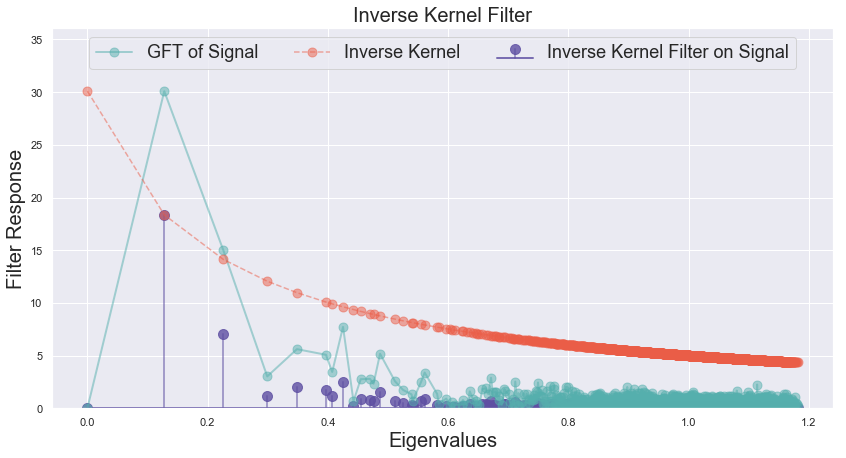

In [15]:
# Inverse Kernel
# Computing Graph Fourier Transform
GFT_x = GFT(labels)

# Computing Inverse Kernel response on Signal
tau= 5.0
IK = inverse_kernel(e, t=tau)@GFT_x

# Computing Inverse Kernel plot alone
IK_p = inverse_kernel(e, t=tau)@np.full((2000,), np.abs(GFT_x).max())

fig, ax = plt.subplots(1,1, figsize=(14,7))

# Plotting Stem-plot for Inverse Kernel Response on Signal
markers,stems,base = ax.stem(e, np.abs(IK), label='Inverse Kernel Filter on Signal')
plt.setp(markers, markersize=10, color=color_codes2[6])
plt.setp(base, color=color_codes2[6], linewidth=2)
plt.setp(stems, color=color_codes1[6], linewidth=2)

#Plotting GFT of Signal for comparison
ax.plot(e, np.abs(GFT_x), color=color_codes1[5], linewidth=2, marker='o', markersize=9, label='GFT of Signal')

#Plotting InverseKernel Alone
ax.plot(e, np.abs(IK_p), color=color_codes1[1], linestyle='--', marker='o', markersize=9,
        label='Inverse Kernel')

#Setting Properties of plot
ax.set_ylabel('Filter Response', fontsize=20)
ax.set_xlabel('Eigenvalues', fontsize=20)
ax.set_title('Inverse Kernel Filter', fontsize=20)
ax.set_ylim([0, np.abs(GFT_x).max()*1.2])
ax.legend(loc='upper center',fontsize=18, ncol=3)

plt.show()

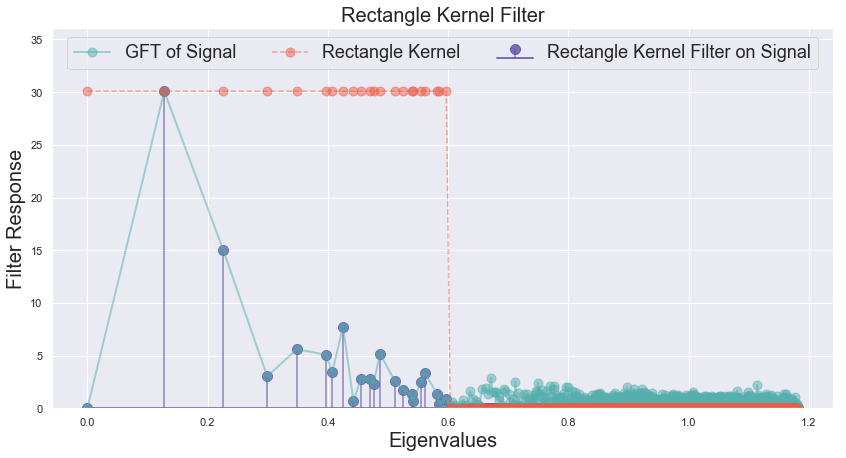

In [16]:
# Rectangle Kernel
RK = graph_filter(labels, 'rectangle_kernel', e=e, lambda_min = 0 , lambda_max =0.6)

# Computing Graph Fourier Transform
GFT_x = GFT(labels)

# Computing Rectangle Kernel response on Signal
l_min = 0.0
l_max = 0.6
RK = rectangle_kernel(e, l_min=l_min, l_max=l_max)@GFT_x

# Computing Rectangle Kernel plot alone
RK_p = rectangle_kernel(e, l_min=l_min, l_max=l_max)@np.full((2000,), np.abs(GFT_x).max())

fig, ax = plt.subplots(1,1, figsize=(14,7))

# Plotting Stem-plot for RectangleKernel Response on Signal
markers,stems,base = ax.stem(e, np.abs(RK), label='Rectangle Kernel Filter on Signal')
plt.setp(markers, markersize=10, color=color_codes2[6])
plt.setp(base, color=color_codes2[6], linewidth=2)
plt.setp(stems, color=color_codes1[6], linewidth=2)

#Plotting GFT of Signal for comparison
ax.plot(e, np.abs(GFT_x), color=color_codes1[5], linewidth=2, marker='o', markersize=9, label='GFT of Signal')

#Plotting Rectangle Kernel Alone
ax.plot(e, np.abs(RK_p), color=color_codes1[1], linestyle='--', marker='o', markersize=9,
        label='Rectangle Kernel')

#Setting Properties of plot
ax.set_ylabel('Filter Response', fontsize=20)
ax.set_xlabel('Eigenvalues', fontsize=20)
ax.set_title('Rectangle Kernel Filter', fontsize=20)
ax.set_ylim([0, np.abs(GFT_x).max()*1.2])
ax.legend(loc='upper center',fontsize=18, ncol=3)

plt.show()

### Question 8

Consider two Dirac impulses arbitrarily placed on your graph. Plot their filtered versions by the three filter kernels implemented in Question 6.

In [17]:
# Creating the Dirac Impulses
graph_dirac= np.zeros(len(e))
dirac1= np.random.randint(0,len(e))
dirac2= np.random.randint(0,len(e))
graph_dirac[dirac1] = 1
graph_dirac[dirac2] = 1

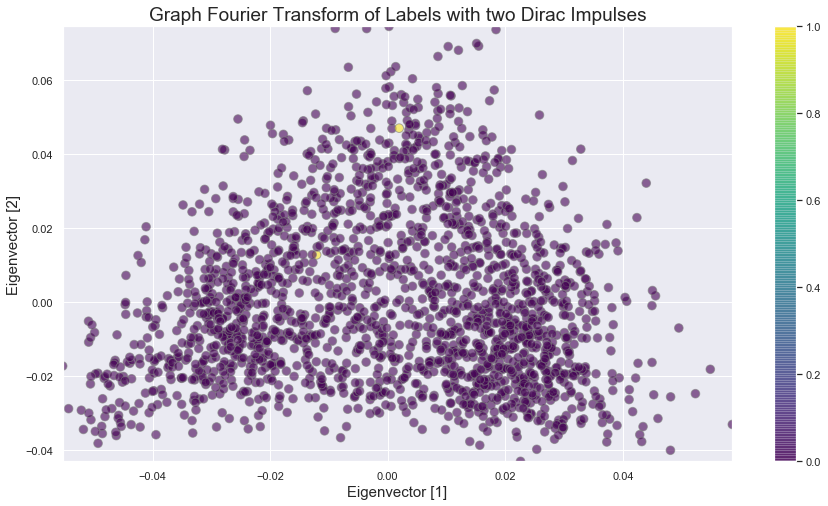

In [18]:
# Plotting the  two Dirac impulses arbitrarily placed on our graph
x = U[:,1]
y = U[:,2]
fig,ax=plt.subplots(1,1,figsize=(15,8))

p_ax = ax.scatter(x, y, c=np.abs(graph_dirac), edgecolors='gray', cmap='viridis', s=75, alpha=0.6, vmin=0.0, 
                  vmax=np.max(graph_dirac))
ax.set_ylim([np.min(y),np.max(y)])
ax.set_xlim([np.min(x),np.max(x)])
ax.set_title('Graph Fourier Transform of Labels with two Dirac Impulses', fontsize=19)
ax.set_xlabel('Eigenvector [1]', fontsize=15)
ax.set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax, ax=ax)
plt.show()

#Appropiate to mention that the dirac impulses are randomly placed and depending on their location in 
#some cases they are difficult to pin-point on the graph visualization but rest assured that they are always placed

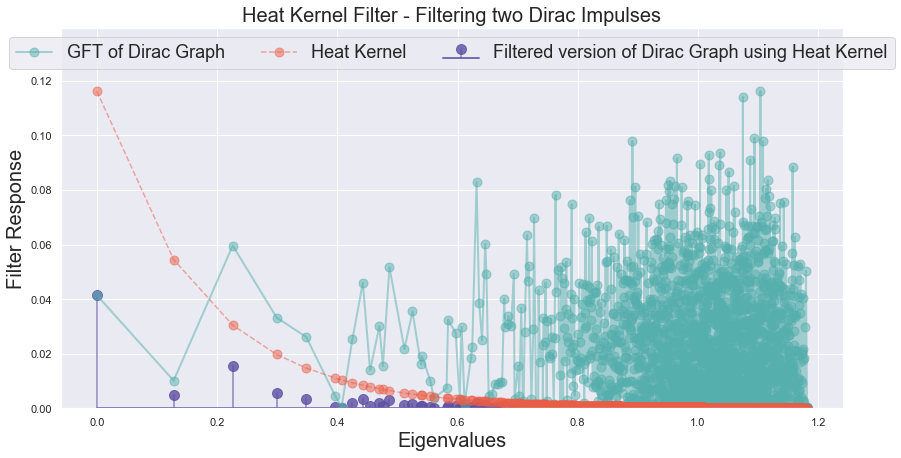

In [19]:
#Heat Kernel

# Computing Graph Fourier Transform
GFT_dirac = GFT(graph_dirac)

# Computing Heat Kernel response 
tau= 7.0
HK_dirac = heat_kernel(e, t=tau)@GFT_dirac

# Computing Heat Kernel plot alone
HK_p = heat_kernel(e, t=tau)@np.full((2000,), np.abs(GFT_dirac).max())

fig, ax = plt.subplots(1,1, figsize=(14,7))

# Plotting Stem-plot for Heat Kernel Response 
markers,stems,base = ax.stem(e, np.abs(HK_dirac), label='Filtered version of Dirac Graph using Heat Kernel')
plt.setp(markers, markersize=10, color=color_codes2[6])
plt.setp(base, color=color_codes2[6], linewidth=2)
plt.setp(stems, color=color_codes1[6], linewidth=2)

#Plotting GFT of Signal for comparison
ax.plot(e, np.abs(GFT_dirac), color=color_codes1[5], linewidth=2, marker='o', markersize=9, label='GFT of Dirac Graph')

#Plotting HeatKernel Alone
ax.plot(e, np.abs(HK_p), color=color_codes1[1], linestyle='--', marker='o', markersize=9,
        label='Heat Kernel')

#Setting Properties of plot
ax.set_ylabel('Filter Response', fontsize=20)
ax.set_xlabel('Eigenvalues', fontsize=20)
ax.set_title('Heat Kernel Filter - Filtering two Dirac Impulses', fontsize=20)
ax.set_ylim([0, np.abs(GFT_dirac).max()*1.2])
ax.legend(loc='upper center',fontsize=18, ncol=3)

plt.show()

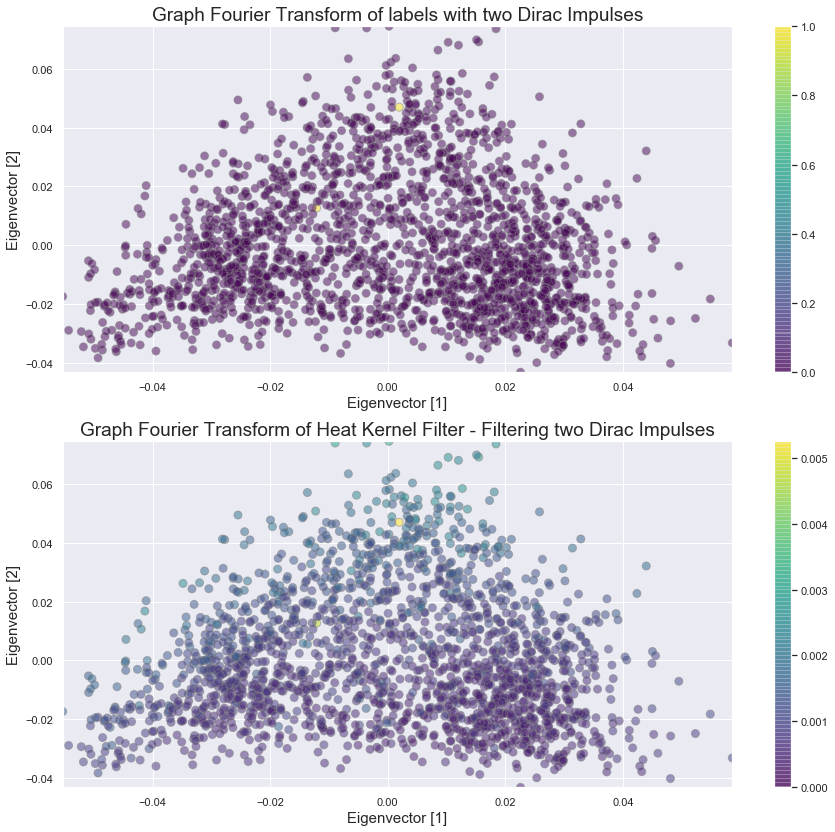

In [20]:
# Heat Kernel - Graph Plot

Dirac_HKR = graph_filter(graph_dirac, 'heat_kernel', tau=7.0)

x = U[:,1]
y = U[:,2]
fig,ax=plt.subplots(2,1,figsize=(15,14))

# Plotting Graph Fourier Transform of labels with two Dirac Impulses
p_ax0 = ax[0].scatter(x, y, c=np.abs(graph_dirac), edgecolors='gray', cmap='viridis', s=65, alpha=0.5, vmin=0.0, 
                  vmax=np.max(np.abs(graph_dirac)))
ax[0].set_ylim([np.min(y),np.max(y)])
ax[0].set_xlim([np.min(x),np.max(x)])
ax[0].set_title('Graph Fourier Transform of labels with two Dirac Impulses', fontsize=19)
ax[0].set_xlabel('Eigenvector [1]', fontsize=15)
ax[0].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax0, ax=ax[0])

#Plotting Graph Fourier Transform of Heat Kernel Filter - Filtering two Dirac Impulses
p_ax1 = ax[1].scatter(x, y, c=np.abs(Dirac_HKR), edgecolors='gray', cmap='viridis', s=65, alpha=0.5, vmin=0.0, 
                  vmax=np.max(np.abs(Dirac_HKR)))
ax[1].set_ylim([np.min(y),np.max(y)])
ax[1].set_xlim([np.min(x),np.max(x)])
ax[1].set_title('Graph Fourier Transform of Heat Kernel Filter - Filtering two Dirac Impulses', fontsize=19)
ax[1].set_xlabel('Eigenvector [1]', fontsize=15)
ax[1].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax1, ax=ax[1])
plt.show()

#Appropiate to mention that the dirac impulses are randomly placed and depending on their location in 
#some cases they are difficult to pin-point on the graph visualization but rest assured that they are always placed

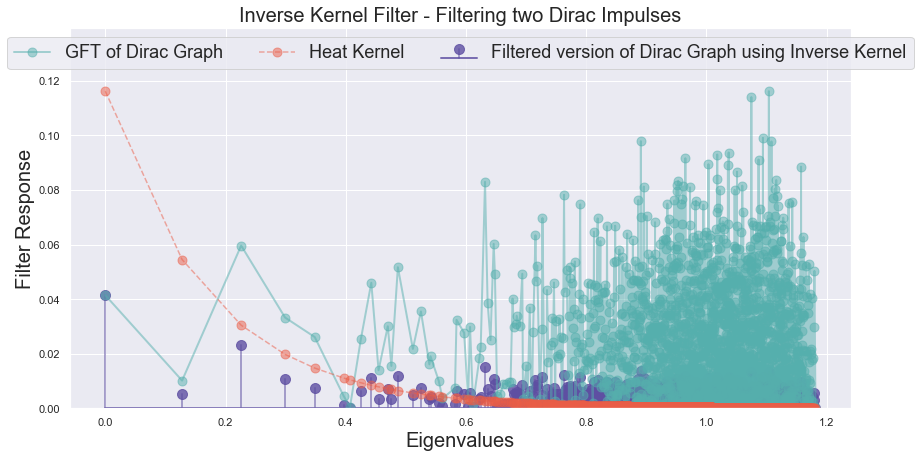

In [21]:
#Inverse Kernel 

# Computing Graph Fourier Transform
GFT_dirac = GFT(graph_dirac)

# Computing Inverse Kernel response
tau= 7.0
IK_dirac = inverse_kernel(e, t=tau)@GFT_dirac

# Computing Inverse Kernel plot alone
IK_p = heat_kernel(e, t=tau)@np.full((2000,), np.abs(GFT_dirac).max())

fig, ax = plt.subplots(1,1, figsize=(14,7))

# Plotting Stem-plot for Inverse Kernel Response 
markers,stems,base = ax.stem(e, np.abs(IK_dirac), label='Filtered version of Dirac Graph using Inverse Kernel')
plt.setp(markers, markersize=10, color=color_codes2[6])
plt.setp(base, color=color_codes2[6], linewidth=2)
plt.setp(stems, color=color_codes1[6], linewidth=2)

#Plotting GFT of Signal for comparison
ax.plot(e, np.abs(GFT_dirac), color=color_codes1[5], linewidth=2, marker='o', markersize=9, label='GFT of Dirac Graph')

#Plotting Inverse Kernel Alone
ax.plot(e, np.abs(IK_p), color=color_codes1[1], linestyle='--', marker='o', markersize=9,
        label='Heat Kernel')

#Setting Properties of plot
ax.set_ylabel('Filter Response', fontsize=20)
ax.set_xlabel('Eigenvalues', fontsize=20)
ax.set_title('Inverse Kernel Filter - Filtering two Dirac Impulses', fontsize=20)
ax.set_ylim([0, np.abs(GFT_dirac).max()*1.2])
ax.legend(loc='upper center',fontsize=18, ncol=3)

plt.show()

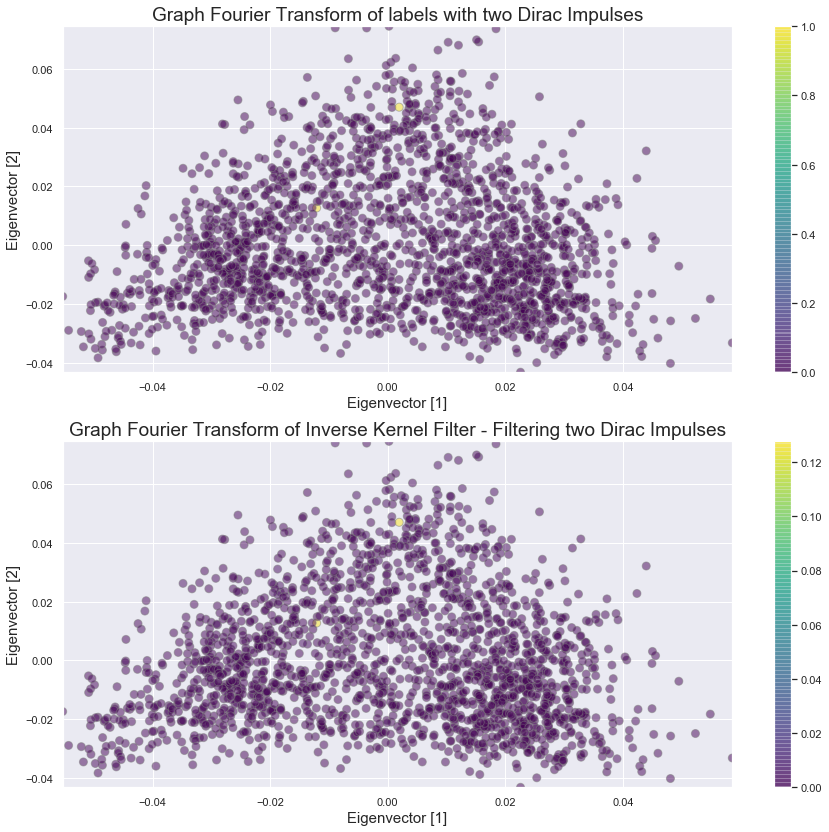

In [22]:
#Inverse Kernel - Graph plot

Dirac_IKR = graph_filter(graph_dirac, 'inverse_kernel', tau=7.0)

x = U[:,1]
y = U[:,2]
fig,ax=plt.subplots(2,1,figsize=(15,14))

# Plotting Graph Fourier Transform of labels with two Dirac Impulses
p_ax0 = ax[0].scatter(x, y, c=np.abs(graph_dirac), edgecolors='gray', cmap='viridis', s=65, alpha=0.5, vmin=0.0, 
                  vmax=np.max(np.abs(graph_dirac)))
ax[0].set_ylim([np.min(y),np.max(y)])
ax[0].set_xlim([np.min(x),np.max(x)])
ax[0].set_title('Graph Fourier Transform of labels with two Dirac Impulses', fontsize=19)
ax[0].set_xlabel('Eigenvector [1]', fontsize=15)
ax[0].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax0, ax=ax[0])

#Plotting Graph Fourier Transform of Inverse Kernel Filter - Filtering two Dirac Impulses
p_ax1 = ax[1].scatter(x, y, c=np.abs(Dirac_IKR), edgecolors='gray', cmap='viridis', s=65, alpha=0.5, vmin=0.0, 
                  vmax=np.max(np.abs(Dirac_IKR)))
ax[1].set_ylim([np.min(y),np.max(y)])
ax[1].set_xlim([np.min(x),np.max(x)])
ax[1].set_title('Graph Fourier Transform of Inverse Kernel Filter - Filtering two Dirac Impulses', fontsize=19)
ax[1].set_xlabel('Eigenvector [1]', fontsize=15)
ax[1].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax1, ax=ax[1])
plt.show()

#Appropiate to mention that the dirac impulses are randomly placed and depending on their location in 
#some cases they are difficult to pin-point on the graph visualization but rest assured that they are always placed

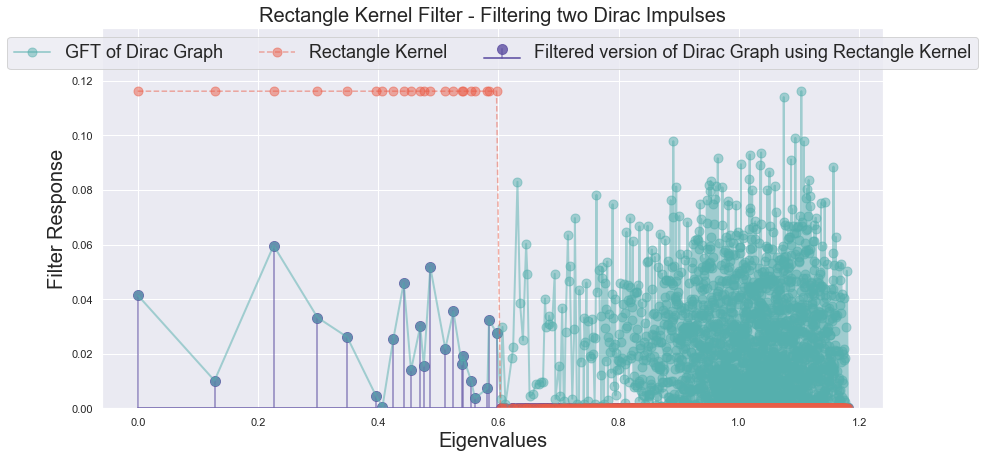

In [23]:
# Rectangle Kernel

# Computing Graph Fourier Transform
GFT_dirac = GFT(graph_dirac)

# Computing Kernel response 
l_min = 0.0
l_max = 0.6
RK_dirac = rectangle_kernel(e, l_min=l_min, l_max=l_max)@GFT_dirac

# Computing Rectangle Kernel plot alone
RK_p = rectangle_kernel(e, l_min=l_min, l_max=l_max)@np.full((2000,), np.abs(GFT_dirac).max())

fig, ax = plt.subplots(1,1, figsize=(14,7))

# Plotting Stem-plot for Rectangle Kernel Response
markers,stems,base = ax.stem(e, np.abs(RK_dirac), label='Filtered version of Dirac Graph using Rectangle Kernel')
plt.setp(markers, markersize=10, color=color_codes2[6])
plt.setp(base, color=color_codes2[6], linewidth=2)
plt.setp(stems, color=color_codes1[6], linewidth=2)

#Plotting GFT of Signal for comparison
ax.plot(e, np.abs(GFT_dirac), color=color_codes1[5], linewidth=2, marker='o', markersize=9, label='GFT of Dirac Graph')

#Plotting Rectangle Kernel Alone
ax.plot(e, np.abs(RK_p), color=color_codes1[1], linestyle='--', marker='o', markersize=9,
        label='Rectangle Kernel')

#Setting Properties of plot
ax.set_ylabel('Filter Response', fontsize=20)
ax.set_xlabel('Eigenvalues', fontsize=20)
ax.set_title('Rectangle Kernel Filter - Filtering two Dirac Impulses', fontsize=20)
ax.set_ylim([0, np.abs(GFT_dirac).max()*1.2])
ax.legend(loc='upper center', fontsize=18, ncol=3)

plt.show()

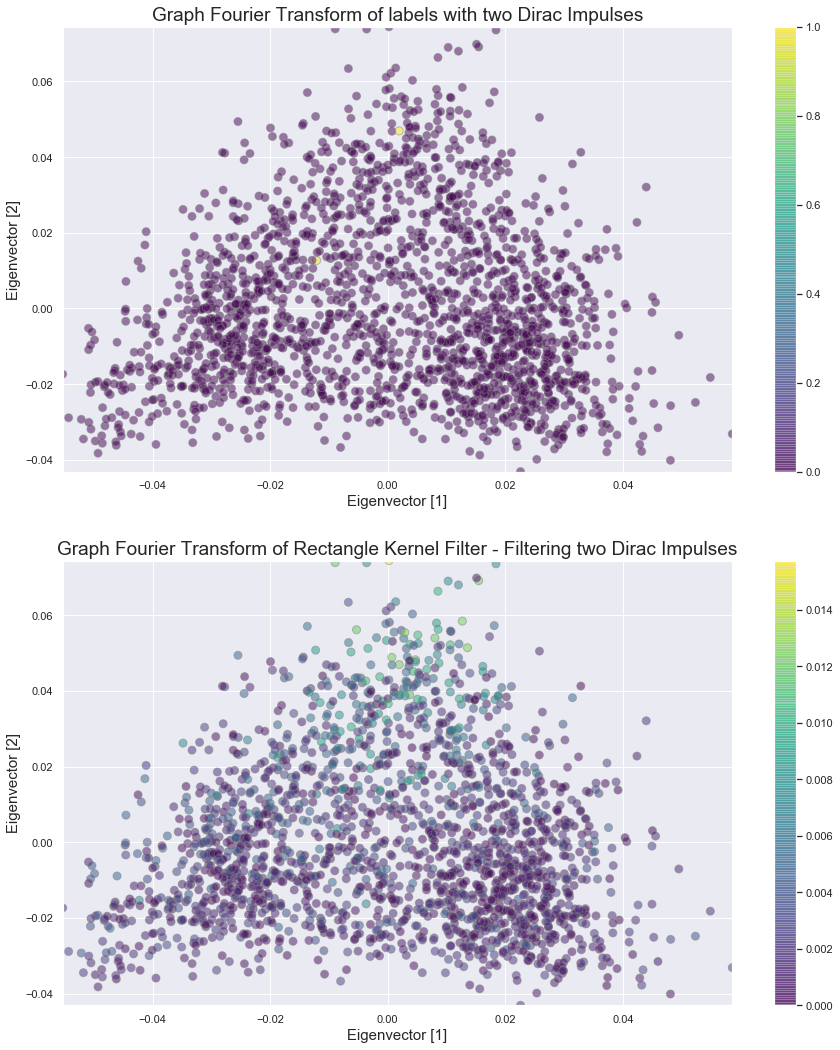

In [24]:
# Rectangle Kernel - Graph plot

Dirac_RKR = graph_filter(graph_dirac, 'rectangle_kernel', e=e, lambda_min = 0 , lambda_max =0.6)

x = U[:,1]
y = U[:,2]
fig,ax=plt.subplots(2,1,figsize=(15,18))

# Plotting Graph Fourier Transform of labels with two Dirac Impulses
p_ax0 = ax[0].scatter(x, y, c=np.abs(graph_dirac), edgecolors='gray', cmap='viridis', s=65, alpha=0.5, vmin=0.0, 
                  vmax=np.max(np.abs(graph_dirac)))
ax[0].set_ylim([np.min(y),np.max(y)])
ax[0].set_xlim([np.min(x),np.max(x)])
ax[0].set_title('Graph Fourier Transform of labels with two Dirac Impulses', fontsize=19)
ax[0].set_xlabel('Eigenvector [1]', fontsize=15)
ax[0].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax0, ax=ax[0])

#Plotting Graph Fourier Transform of Rectangle Kernel Filter - Filtering two Dirac Impulses
p_ax1 = ax[1].scatter(x, y, c=np.abs(Dirac_RKR), edgecolors='gray', cmap='viridis', s=65, alpha=0.5, vmin=0.0, 
                  vmax=np.max(np.abs(Dirac_RKR)))
ax[1].set_ylim([np.min(y),np.max(y)])
ax[1].set_xlim([np.min(x),np.max(x)])
ax[1].set_title('Graph Fourier Transform of Rectangle Kernel Filter - Filtering two Dirac Impulses', fontsize=19)
ax[1].set_xlabel('Eigenvector [1]', fontsize=15)
ax[1].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax1, ax=ax[1])
plt.show()

#Appropiate to mention that the dirac impulses are randomly placed and depending on their location in 
#some cases they are difficult to pin-point on the graph visualization but rest assured that they are always placed

Comment on the "diffusion" of the Diracs induced by the filters. What does it say about the "communication" of information across your network? Relate that to the network connectivity measures that you analyzed during the previous milestones.

**Answer:**

It is diffusing all around the nodes where the dirac implulses are located. It means our network is well connected and communication of  information is strong across our network. Basically our nodes are well connected to the surrounding nodes, this fact results in good diffusion to the surrounding nodes after applying the kernals.




## 3 - De-noising

In this section we will add some centered Gaussian noise to your feature/label signal and attempt to recover it.

### Question 9

In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.

_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.

In [25]:
# Computing the variance of the labels
var_lab = np.var(labels)
print(var_lab)

1.0


In [26]:
# Computing the noise variance considering SNR=1.5
noise_variance = var_lab / 1.5

# Creating "noisy_measurements" (already defined in the Milestone)
noisy_measurements = labels + np.sqrt(noise_variance) * np.random.randn(n_nodes)

print(noisy_measurements)

[-0.29749068  0.14754147 -0.44018402 ... -0.17051381  2.17106384
  0.56115866]


### Question 10

In the denoising setting, a common graph signal processing assumption is that the signal $z$ that we want to recover is "smooth", in the sense that $\|\nabla_G z\|_2 = \sqrt{z^{\top} L z}$ is small, while remaining "close" to the measurements that we start with. This leads to denoising by solving the following optimization problem:

$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

where $y \in \mathbb{R}^{N}$ is the vector of noisy measurements.

Derive the close form solution to this problem giving $z^\star$ as a function of $y$, $\gamma$ and $L$. Does this solution correspond to any graph filtering operation that you know?

**Answer:**

We compute the derivative of the function in order to obtain the $z^\star$ which is minimizing it.

$\frac{\mathrm d}{\mathrm d z} [  \|z - y\|_2^2 + \gamma z^T L z ] = 0$

$\frac{\mathrm d}{\mathrm d z} [  \|z - y\|_2^2 + \gamma \|z S^T\|_2^2] = 0$

$ \frac{\mathrm d}{\mathrm d z}  [  (z_1 - y_1)^2 + (z_2 - y_2)^2 + ... + (z_n - y_n)^2 + \gamma (L_1 z_1^2 + L_2 z_2^2 + ... + L_n z_n^2)] = 0$

$ 2 (z^* - y) +  2 \gamma L z^* = 0 $

Where we can obtain the close form solution of $z^*$

$ z^* = \frac{y}{I + \gamma L} $



### Question 11

Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).

In [27]:
# Denoising 'noisy_measurements' by passing them throught the filters 'heat_kernel', 'inverse_kernel' and 'rectangle_kernel'

z_heat_denoised = graph_filter(noisy_measurements, 'heat_kernel', tau=3)
z_inv_denoised = graph_filter(noisy_measurements, 'inverse_kernel', tau=3)

l_min = 0.0
l_max = 0.6
z_rect_denoised = graph_filter(noisy_measurements, 'rectangle_kernel', lambda_min=l_min , lambda_max=l_max)

Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error 
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
where $z$ is the plotted signal.

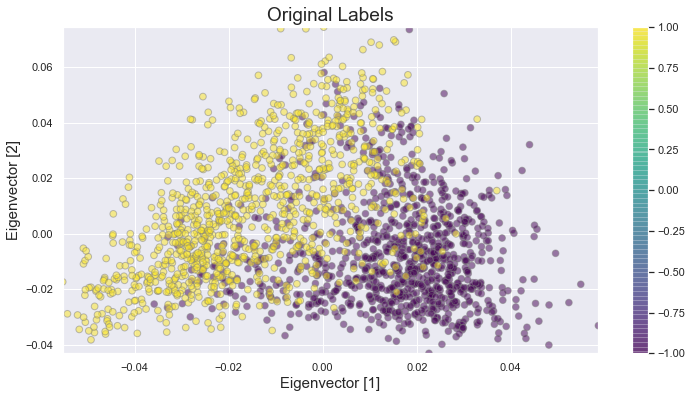

In [28]:
# The original label signal
x = U[:,1]
y = U[:,2]
fig,ax=plt.subplots(1,1,figsize=(12,6))
p_ax = ax.scatter(x, y, c=labels, edgecolors='gray', cmap='viridis', s=45, alpha=0.5, 
                  vmin=np.min(labels), vmax=np.max(labels))
ax.set_ylim([np.min(y),np.max(y)])
ax.set_xlim([np.min(x),np.max(x)])
ax.set_title('Original Labels', fontsize=19)
ax.set_xlabel('Eigenvector [1]', fontsize=15)
ax.set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax, ax=ax)
plt.show()

The error of the noisy measurements is: 0.8436385695744867


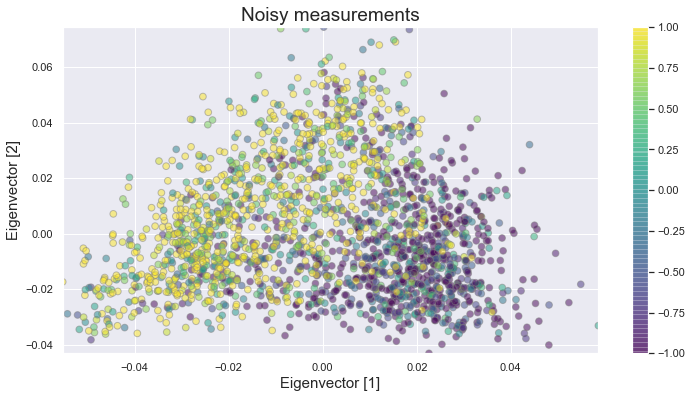

In [29]:
# Noisy measurements

#Computing the error of the noisy measurements
re_noisy = np.linalg.norm(labels - noisy_measurements)/np.linalg.norm(labels)

print('The error of the noisy measurements is:', re_noisy)

#Plotting the noisy measurements
x = U[:,1]
y = U[:,2]
fig,ax=plt.subplots(1,1,figsize=(12,6))
p_ax = ax.scatter(x, y, c=noisy_measurements, edgecolors='gray', cmap='viridis', s=45, alpha=0.5, 
                  vmin=np.min(labels), vmax=np.max(labels))
ax.set_ylim([np.min(y),np.max(y)])
ax.set_xlim([np.min(x),np.max(x)])
ax.set_title('Noisy measurements', fontsize=19)
ax.set_xlabel('Eigenvector [1]', fontsize=15)
ax.set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax, ax=ax)
plt.show()

The error using Heat Kernel (without threshold) is: 0.5080892912634896
The error using Heat Kernel (with threshold) is: 0.412310562561766


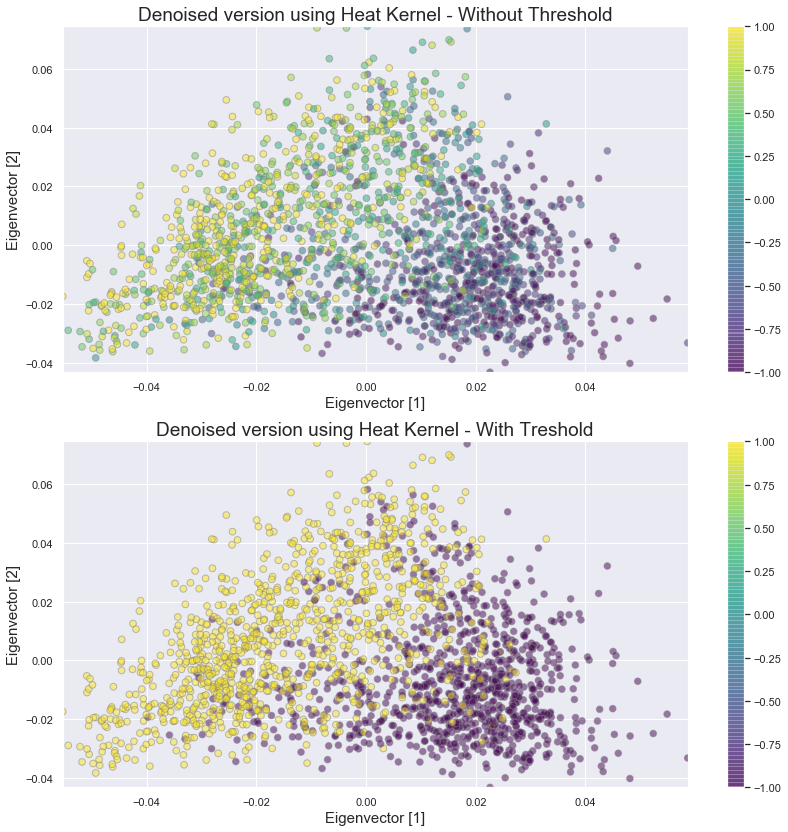

In [30]:
# Denoised version using Heat Kernel
z_heat_denoised = graph_filter(noisy_measurements, 'heat_kernel', tau=1)

#Applying a threshold for better results as we want to go back to our binarized network
z_heat_thr = z_heat_denoised.copy()
z_heat_thr[z_heat_thr>=0] = 1
z_heat_thr[z_heat_thr<0] = -1

#Computing the error of the noisy measurements
re_heat = np.linalg.norm(labels - z_heat_denoised)/np.linalg.norm(labels)
re_heat_thr = np.linalg.norm(labels - z_heat_thr)/np.linalg.norm(labels)

print('The error using Heat Kernel (without threshold) is:', re_heat)
print('The error using Heat Kernel (with threshold) is:', re_heat_thr)

#Plotting the Denoised version using Heat Kernel
x = U[:,1]
y = U[:,2]
fig,ax=plt.subplots(2,1,figsize=(14,14))

# First Plot: without thresholding
p_ax0 = ax[0].scatter(x, y, c = z_heat_denoised, edgecolors='gray', cmap='viridis', s=45, alpha=0.5, 
                  vmin=np.min(labels), vmax=np.max(labels))
ax[0].set_ylim([np.min(y),np.max(y)])
ax[0].set_xlim([np.min(x),np.max(x)])
ax[0].set_title('Denoised version using Heat Kernel - Without Threshold', fontsize=19)
ax[0].set_xlabel('Eigenvector [1]', fontsize=15)
ax[0].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax0, ax=ax[0])

# Second plot: With Thresholding
p_ax1 = ax[1].scatter(x, y, c = z_heat_thr, edgecolors='gray', cmap='viridis', s=45, alpha=0.5, 
                  vmin=np.min(labels), vmax=np.max(labels))
ax[1].set_ylim([np.min(y),np.max(y)])
ax[1].set_xlim([np.min(x),np.max(x)])
ax[1].set_title('Denoised version using Heat Kernel - With Treshold', fontsize=19)
ax[1].set_xlabel('Eigenvector [1]', fontsize=15)
ax[1].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax1, ax=ax[1])

plt.show()

The error using Inverse Kernel (without threshold) is: 0.5315747042249266
The error using Inverse Kernel (with threshold) is: 0.45825756949558394


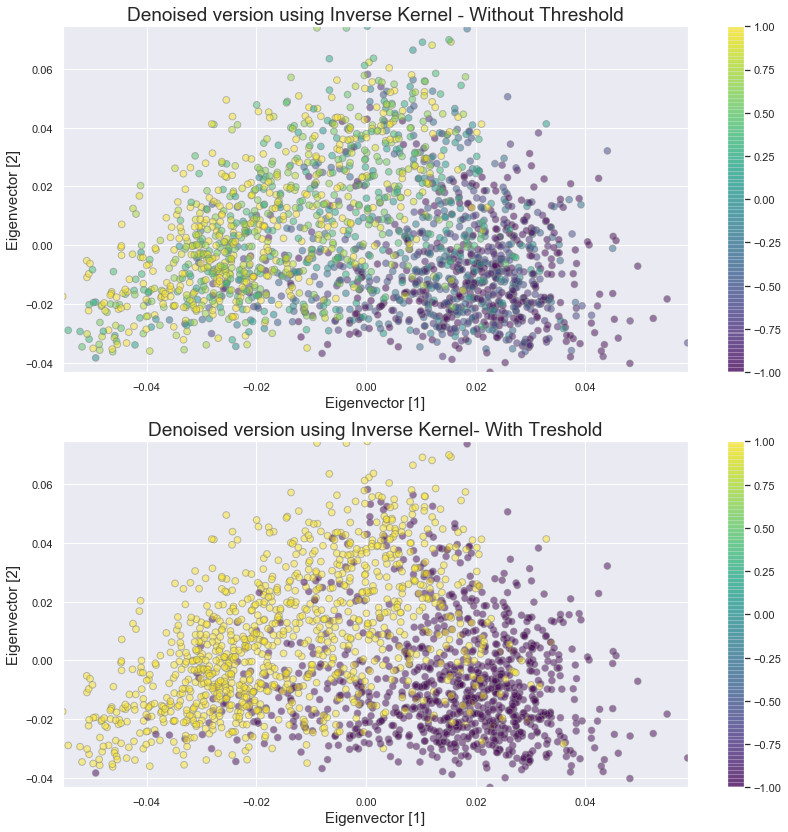

In [31]:
# Denoised version using Inverse Kernel
z_inv_denoised = graph_filter(noisy_measurements, 'inverse_kernel', tau=1)

#Applying a threshold for better results as we want to go back to our binarized network
z_inv_thr = z_inv_denoised.copy()
z_inv_thr[z_inv_thr>=0] = 1
z_inv_thr[z_inv_thr<0] = -1

#Computing the error of the noisy measurements
re_inverse = np.linalg.norm(labels - z_inv_denoised)/np.linalg.norm(labels)
re_inverse_thr = np.linalg.norm(labels - z_inv_thr)/np.linalg.norm(labels)

print('The error using Inverse Kernel (without threshold) is:', re_inverse)
print('The error using Inverse Kernel (with threshold) is:', re_inverse_thr)

#Plotting the Denoised version using Inverse Kernel
x = U[:,1]
y = U[:,2]
fig,ax=plt.subplots(2,1,figsize=(14,14))

# First Plot: without thresholding
p_ax0 = ax[0].scatter(x, y, c = z_inv_denoised, edgecolors='gray', cmap='viridis', s=45, alpha=0.5, 
                  vmin=np.min(labels), vmax=np.max(labels))
ax[0].set_ylim([np.min(y),np.max(y)])
ax[0].set_xlim([np.min(x),np.max(x)])
ax[0].set_title('Denoised version using Inverse Kernel - Without Threshold', fontsize=19)
ax[0].set_xlabel('Eigenvector [1]', fontsize=15)
ax[0].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax0, ax=ax[0])

# Second plot: With Thresholding
p_ax1 = ax[1].scatter(x, y, c = z_inv_thr, edgecolors='gray', cmap='viridis', s=45, alpha=0.5, 
                  vmin=np.min(labels), vmax=np.max(labels))
ax[1].set_ylim([np.min(y),np.max(y)])
ax[1].set_xlim([np.min(x),np.max(x)])
ax[1].set_title('Denoised version using Inverse Kernel- With Treshold', fontsize=19)
ax[1].set_xlabel('Eigenvector [1]', fontsize=15)
ax[1].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax1, ax=ax[1])

plt.show()

The error using Rectangle Kernel (Without threshold) is: 0.5620474350272175
The error using Rectangle Kernel (with threshold) is: 0.589915248150105


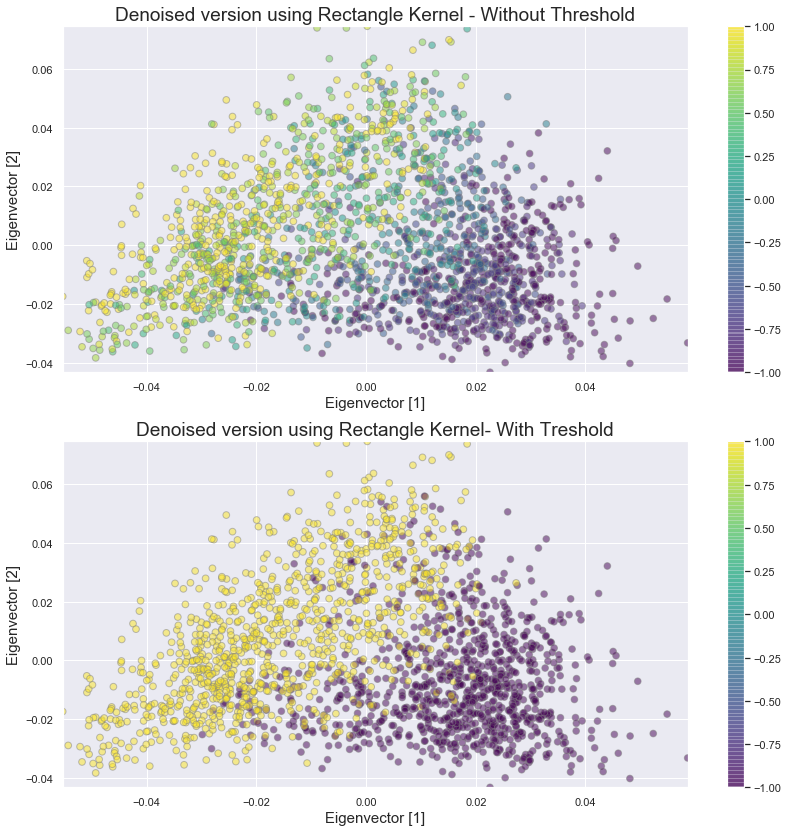

In [32]:
# Denoised version using Rectangle Kernel
l_min = 0.1
l_max = 0.8
z_rect_denoised = graph_filter(noisy_measurements, 'rectangle_kernel', lambda_min=l_min , lambda_max=l_max)

#Applying a threshold for better results as we want to go back to our binarized network
z_rect_thr = z_rect_denoised.copy()
z_rect_thr[z_rect_thr>=0] = 1
z_rect_thr[z_rect_thr<0] = -1

#Computing the error of the noisy measurements
re_rectangle = np.linalg.norm(labels - z_rect_denoised)/np.linalg.norm(labels)
re_rectangle_thr = np.linalg.norm(labels - z_rect_thr)/np.linalg.norm(labels)

print('The error using Rectangle Kernel (Without threshold) is:', re_rectangle)
print('The error using Rectangle Kernel (with threshold) is:', re_rectangle_thr)

#Plotting the Denoised version using Rectangle Kernel
x = U[:,1]
y = U[:,2]
fig,ax=plt.subplots(2,1,figsize=(14,14))

# First Plot: without thresholding
p_ax0 = ax[0].scatter(x, y, c = z_rect_denoised, edgecolors='gray', cmap='viridis', s=45, alpha=0.5, 
                  vmin=np.min(labels), vmax=np.max(labels))
ax[0].set_ylim([np.min(y),np.max(y)])
ax[0].set_xlim([np.min(x),np.max(x)])
ax[0].set_title('Denoised version using Rectangle Kernel - Without Threshold', fontsize=19)
ax[0].set_xlabel('Eigenvector [1]', fontsize=15)
ax[0].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax0, ax=ax[0])

# Second plot: With Thresholding
p_ax1 = ax[1].scatter(x, y, c = z_rect_thr, edgecolors='gray', cmap='viridis', s=45, alpha=0.5, 
                  vmin=np.min(labels), vmax=np.max(labels))
ax[1].set_ylim([np.min(y),np.max(y)])
ax[1].set_xlim([np.min(x),np.max(x)])
ax[1].set_title('Denoised version using Rectangle Kernel- With Treshold', fontsize=19)
ax[1].set_xlabel('Eigenvector [1]', fontsize=15)
ax[1].set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax1, ax=ax[1])

plt.show()

Finally, overlay on the same plot the GFT of all five signals above.

In [33]:
# Applying GFT for all 5 signals - Without Threshold
# Computing Graph Fourier Transform

GFT_original = GFT(labels)
GFT_noisy = GFT(noisy_measurements)
GFT_heat = GFT(z_heat_denoised)
GFT_inverse = GFT(z_inv_denoised)
GFT_rectangle = GFT(z_rect_denoised)

GFT_total = [np.abs(GFT_original), np.abs(GFT_noisy), np.abs(GFT_heat), np.abs(GFT_inverse), np.abs(GFT_rectangle)]

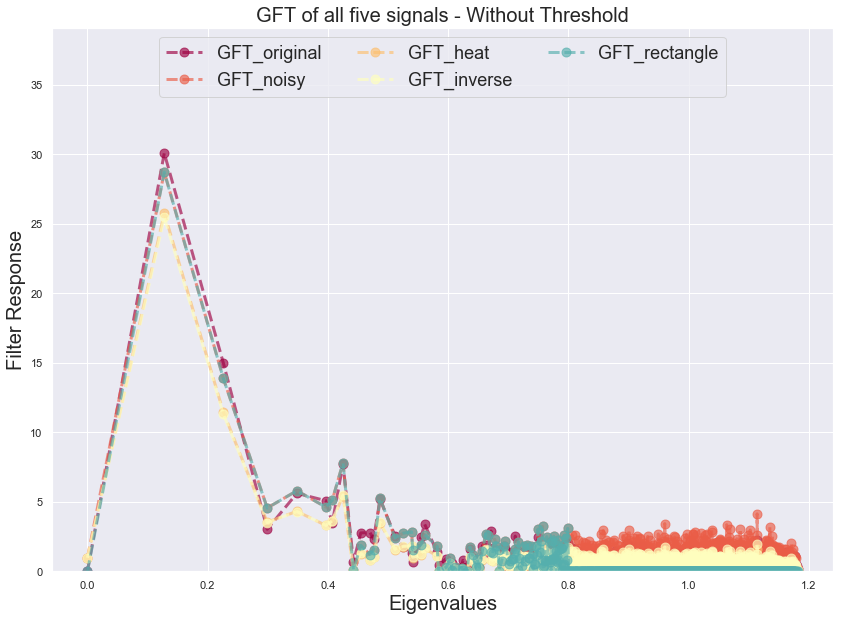

In [34]:
# Plotting - all 5 signals - Without Threshold

fig, ax = plt.subplots(1,1, figsize=(14,10))

#Plotting GFT of Signal for comparison
#Plotting the Five Signals

ax.plot(e, np.abs(GFT_original), color=color_codes3[0], linewidth=3, linestyle='--', 
        marker='o', markersize=9, label='GFT_original')

ax.plot(e, np.abs(GFT_noisy), color=color_codes3[1],linewidth=3, linestyle='--', marker='o', markersize=9,
        label='GFT_noisy')

ax.plot(e, np.abs(GFT_heat), color=color_codes3[2],linewidth=3, linestyle='--', marker='o', markersize=9,
        label='GFT_heat')

ax.plot(e, np.abs(GFT_inverse), color=color_codes3[3],linewidth=3, linestyle='--', marker='o', markersize=9,
        label='GFT_inverse')

ax.plot(e, np.abs(GFT_rectangle), color=color_codes3[5],linewidth=3, linestyle='--', marker='o', markersize=9,
        label='GFT_rectangle')


#Setting Properties of plot
ax.set_ylabel('Filter Response', fontsize=20)
ax.set_xlabel('Eigenvalues', fontsize=20)
ax.set_title('GFT of all five signals - Without Threshold', fontsize=20)
ax.set_ylim([0, np.abs(GFT_total).max()*1.3])
ax.legend(loc='upper center', fontsize=18, ncol=3)

plt.show()

In [35]:
# Applying GFT for all 5 signals - Threshold
# Computing Graph Fourier Transform
z_rect_thr
GFT_original = GFT(labels)
GFT_noisy = GFT(noisy_measurements)
GFT_heat_thr = GFT(z_heat_thr)
GFT_inverse_thr = GFT(z_inv_thr)
GFT_rectangle_thr = GFT(z_rect_thr)

GFT_total = [np.abs(GFT_original), np.abs(GFT_noisy), np.abs(GFT_heat_thr), np.abs(GFT_inverse_thr), np.abs(GFT_rectangle_thr)]

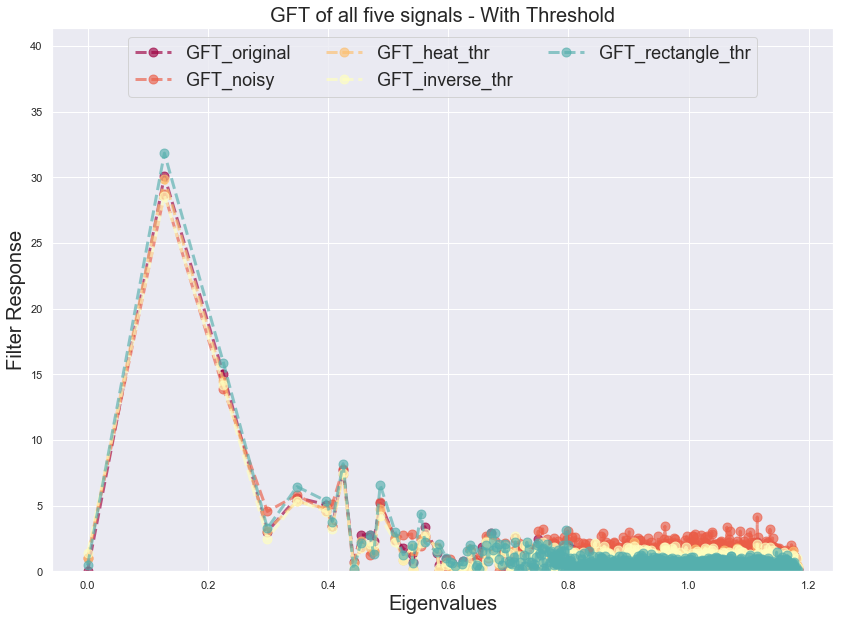

In [36]:
# Plotting - all 5 signals - With Threshold

fig, ax = plt.subplots(1,1, figsize=(14,10))

#Plotting GFT of Signal for comparison
#Plotting the Five Signals

ax.plot(e, np.abs(GFT_original), color=color_codes3[0], linewidth=3, linestyle='--', 
        marker='o', markersize=9, label='GFT_original')

ax.plot(e, np.abs(GFT_noisy), color=color_codes3[1],linewidth=3, linestyle='--', marker='o', markersize=9,
        label='GFT_noisy')

ax.plot(e, np.abs(GFT_heat_thr), color=color_codes3[2],linewidth=3, linestyle='--', marker='o', markersize=9,
        label='GFT_heat_thr')

ax.plot(e, np.abs(GFT_inverse_thr), color=color_codes3[3],linewidth=3, linestyle='--', marker='o', markersize=9,
        label='GFT_inverse_thr')

ax.plot(e, np.abs(GFT_rectangle_thr), color=color_codes3[5],linewidth=3, linestyle='--', marker='o', markersize=9,
        label='GFT_rectangle_thr')


#Setting Properties of plot
ax.set_ylabel('Filter Response', fontsize=20)
ax.set_xlabel('Eigenvalues', fontsize=20)
ax.set_title('GFT of all five signals - With Threshold', fontsize=20)
ax.set_ylim([0, np.abs(GFT_total).max()*1.3])
ax.legend(loc='upper center', fontsize=18, ncol=3)

plt.show()

### Question 12

Comment on which denoised version seems to best match the original label signal. What is the underlying assumption behind the three filtering approaches? Do you think it holds for your label signal? Why?

**Answer:**

Although all denoised versions are appropiate, we observe the `heat denoised` version works the best realative to others in our case. All of the kernals are basically low pass filters. The underlying approach behind the heat kernal is the physical phenomena in heat diffusion, inverse kernel is based on the relation $(I + t L)^{-1}$ between the output and the input signals of the filter, while the rectangle kernal completely eliminates high frequency components by setting a threshold to only pass low frequency components.

With respect to our lables/network, heat kerel holds most sense as our graph is very well connected and has strong clustering with the fact that we have hip-hop track, rock tracks and fusion tracks (a mixture of rock and hip-hop). Thus, the phenomena of heat diffusion is appropiate in our network with respect to the spread and connectivity of our network. Also, the error percentage being the lowest and the visualisation after filtering using the heat kernal  being pleasing also confirms our analysis.

## 4 - Transductive learning

It is often the case in large networks that we can only afford to query properties/labels on a small subset of nodes. Nonetheless, if the underlying labels signal is "regular" enough, we might still be able to recover a good approximation of it by solving an offline variational problem, with constraints on the values of the measured nodes. 

In this section, we will be interested in solving such transductive learning problems by minimizing a (semi-) p-norm of the graph gradient applied to the signal of interest:

$$
\text{arg} \, \underset{z|_S = y}{\min} \|\nabla_G z\|_p^p,
$$

where $S$ is the set of measured nodes.

In English, we can say that we are looking for solutions with small "aggregated local variations", as measured by $\|\nabla_G z\|_p^p = \sum_{i=1}^{n} \sum_{j=1}^{n} \left( \sqrt{W_{ij}} |z[i] - z[j]| \right)^p,$ while satisfying the measurement constraints $z[i] = y[i]$ for $i \in S.$

We will work with two cases, according to the choices $p=1$ or $p=2.$ For $p=1,$ the problem is known as "interpolation by graph total-variation minimization," whereas for $p=2$ it is sometimes called "interpolation by Tikhonov regularization".

In order to solve these variational problems with the black-box solver provided to you, you will use the [pyunlocbox](https://pyunlocbox.readthedocs.io). This toolbox implements iterative solvers based on so-called ["proximal-splitting"](https://en.wikipedia.org/wiki/Proximal_gradient_method) methods.

### Question 13

Throughout this section, we will consider only a binarized version of your label signal. If your variable `labels` currently has values other than $\{-1, 1\},$ threshold them so that those are the only values taken in this vector. This can be done for example by choosing a number $t \in \mathbb{R}$ and then setting $\text{labels_bin}[i] = 1$ if $\text{labels}[i] \geq t$ and $\text{labels_bin}[i] = 0$ otherwise.

In [37]:
# Considering a binarized version of label signal
# We already defined labels for Hip-Hop = -1 and Rock = +1
labels_bin = labels
print(np.size(labels))

2000


Now, subsample this binarized label signal by $70\%$ by choosing, uniformly at random, $30\%$ of the nodes whose labels we will keep.

You will do this by computing a "measurement mask" vector `w` with `1.0`'s at the measured coordinates, and $0.0$'s otherwise.

In [54]:
# Defining the ratio of labels that are kept (30 %)
mn_ratio = 0.3
m = int(mn_ratio * n_nodes)  # Number of measurements.

print(m)

600


In [55]:
idx = np.sort(np.random.choice(labels_bin.shape[0], m, replace=False))

# Defining the 'measurement mask'
w = np.zeros((labels_bin.shape[0]))
w[idx] = 1.0

print(sum(w))

600.0


Plot the subsampled signal on the graph. _Hint:_ you might want to set to `numpy.nan` the values of the un-measured nodes for a cleaner plot.

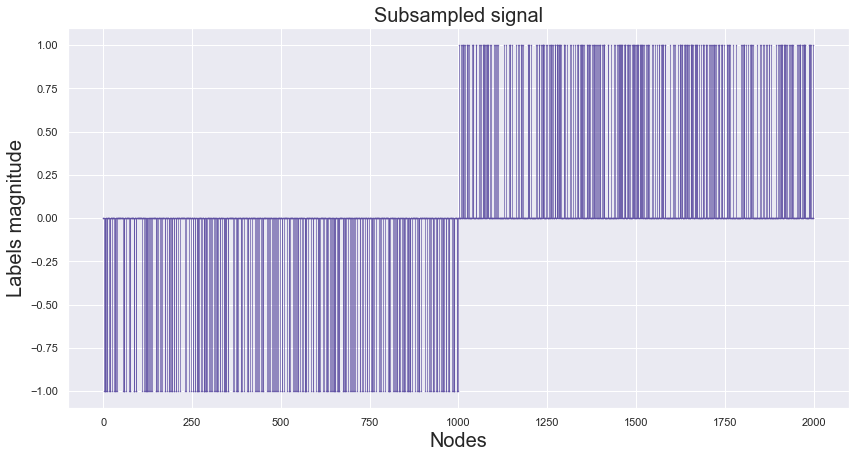

In [40]:
# Filling to nan the un-measured values
signal = w * labels_bin

plt.rcParams['figure.figsize'] = (16, 8)
fig, ax= plt.subplots(1, 1, figsize=(14,7))

# Plotting Stem-plot for Kernel Response on Signal
markers,stems,base = ax.stem(range(labels_bin.shape[0]), signal, label='Inverse Kernel Filter on Signal')
plt.setp(markers, markersize=0.5, color=color_codes2[6])
plt.setp(base, color=color_codes2[6], linewidth=0.8)
plt.setp(stems, color=color_codes2[6], linewidth=0.8)
plt.ylabel('Labels magnitude', fontsize=20)
plt.xlabel('Nodes', fontsize=20)
plt.title('Subsampled signal', fontsize=20)
plt.show()

### Interlude

For the solution of the variational problems you can use the following function as a "black-box". 

You will just need to provide a `gradient` matrix (which you should already have from Section 0), and an orthogonal projection operator `P` onto the span of the measured coordinates (made precise in the next question).

In [40]:
def graph_pnorm_interpolation(gradient, P, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

### Question 14

During the iterations of the algorithm used for solving the variational problem, we have to make sure that the labels at the measured nodes stay the same. We will do this by means of an operator `P` which, given a vector $a \in \mathbb{R}^{N},$ returns another vector $b \in \mathbb{R}^{N}$ satisfying $b[i] = \text{labels_bin}[i]$ for every node $i$ in the set $S$ of known labels, and $b[i] = a[i]$ otherwise. Write in the cell below the function for this orthogonal projection operator `P`.

_Hint:_ remember you have already computed the mask `w`.

In [56]:
def P(a):
    b = np.zeros((a.shape[0],))
    for i in range(labels_bin.shape[0]):
        if w[i] == 1:
            b[i] = labels_bin[i]
        elif w[i] == 0:
            b[i] = a[i]
    return b

### Question 15

Solve the variational problems for $p = 1$ and $p = 2$. Record the solution for the $1-$norm minimization under `sol_1norm_min` and the one for $2-$norm minimization under `sol_2norm_min`.

Compute also binarized versions of these solutions by thresholding the values with respect to $0$, that is, non-negative values become `1.0`, while negative values become `-1.0`. Store those binarized versions under `sol_1norm_bin` and `sol_2norm_bin`, respectively.

In [57]:
# Computing the solution to the problem using the defined 'gradient' and the defined operator 'P'

sol_1norm_min = graph_pnorm_interpolation(gradient_sparse, P, p=1., x0=np.random.randn(n_nodes))

sol_2norm_min = graph_pnorm_interpolation(gradient_sparse, P,p=2., x0=np.random.randn(n_nodes))

threshold = 0

# Since our labels are already binarized with respect to 0 being: Hip-Hop = -1 and Rock = +1 we don't need to compute
# another solution to the problem


Solution found after 40 iterations:
    objective function f(sol) = 4.202097e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.934780e+03
    stopping criterion: RTOL


In [58]:
thresh = 0.0
sol_1norm_min[sol_1norm_min<=thresh] = -1
sol_1norm_min[sol_1norm_min>thresh] = 1

sol_2norm_min[sol_2norm_min<=thresh] = -1
sol_2norm_min[sol_2norm_min>thresh] = 1

In [59]:
# Computing the relative error for the two solutions

rel_err1 = np.linalg.norm(labels_bin - sol_1norm_min)/np.linalg.norm(labels_bin)
rel_err2 = np.linalg.norm(labels_bin - sol_2norm_min)/np.linalg.norm(labels_bin)

print('The relative error using p=1 is:', rel_err1)
print('The relative error using p=2 is:', rel_err2)

The relative error using p=1 is: 0.9622889378975527
The relative error using p=2 is: 1.1704699910719625


Plot, on your graph, the original `labels_bin` signal, as well as the solutions to the variational problems (both binarized and otherwise). Indicate on each plot the value of the relative error $\text{rel-err} = \frac{\|\text{labels_bin} - z\|_2}{\|\text{labels_bin}\|_2}$, where $z$ is the signal in the corresponding plot.

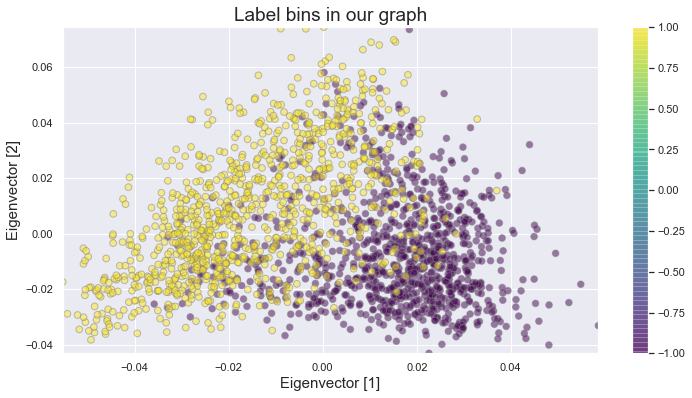

In [46]:
#Plotting the labels_bin in the graph
x = U[:,1]
y = U[:,2]
fig,ax=plt.subplots(1,1,figsize=(12,6))
p_ax = ax.scatter(x, y, c = labels_bin, edgecolors='gray', cmap='viridis', s=45, alpha=0.5, vmin=np.min(labels), vmax=np.max(labels))
ax.set_ylim([np.min(y),np.max(y)])
ax.set_xlim([np.min(x),np.max(x)])
ax.set_title('Label bins in our graph', fontsize=19)
ax.set_xlabel('Eigenvector [1]', fontsize=15)
ax.set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax, ax=ax)
plt.show()

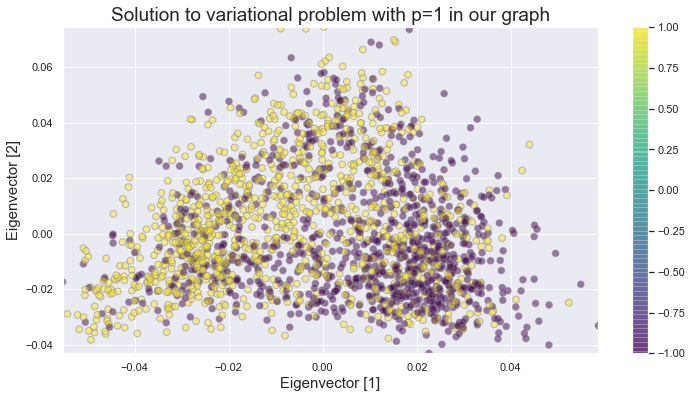

In [47]:
#Plotting Variational problem solution using p=1
x = U[:,1]
y = U[:,2]
fig,ax=plt.subplots(1,1,figsize=(12,6))
p_ax = ax.scatter(x, y, c = sol_1norm_min, edgecolors='gray', cmap='viridis', s=45, alpha=0.5, vmin=np.min(labels), vmax=np.max(labels))
ax.set_ylim([np.min(y),np.max(y)])
ax.set_xlim([np.min(x),np.max(x)])
ax.set_title('Solution to variational problem with p=1 in our graph', fontsize=19)
ax.set_xlabel('Eigenvector [1]', fontsize=15)
ax.set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax, ax=ax)
plt.show()

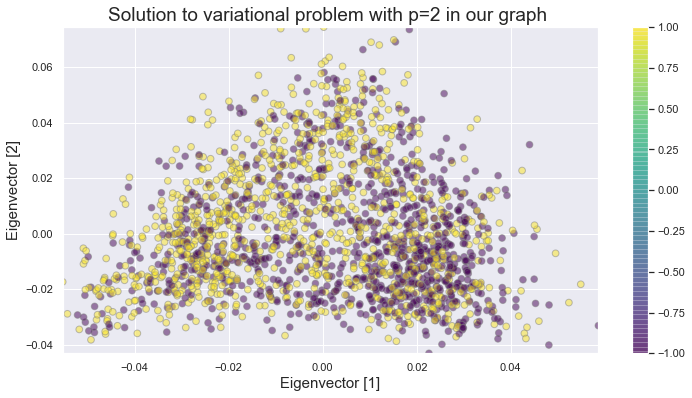

In [48]:
#Plotting Variational problem solution using p=2
x = U[:,1]
y = U[:,2]
fig,ax=plt.subplots(1,1,figsize=(12,6))
p_ax = ax.scatter(x, y, c = sol_2norm_min, edgecolors='gray', cmap='viridis', s=45, alpha=0.5, vmin=np.min(labels), vmax=np.max(labels))
ax.set_ylim([np.min(y),np.max(y)])
ax.set_xlim([np.min(x),np.max(x)])
ax.set_title('Solution to variational problem with p=2 in our graph ', fontsize=19)
ax.set_xlabel('Eigenvector [1]', fontsize=15)
ax.set_ylabel('Eigenvector [2]', fontsize=15)
fig.colorbar(p_ax, ax=ax)
plt.show()

### Question 16

Now that you have got a feeling for the sort of solutions that the transductive learning problems studied can give, we will see what is the effect of the number of measurements on the accuracy of both $p-$norm minimization problems.

Towards this goal, you will write a `phase_transition()` function. This function will basically go over all the procedures that you have implemented in this section, but for varying numbers of measurements and thresholding values. It will also compute the relative error, $\text{rel-err},$ of the solutions and average them over a number of trials.

The output of the `phase_transition()` function has to be a matrix with `len(mn_ratios)` columns and `len(thresholds)` rows. Each pixel $(i,j)$ in the output matrix has to contain the average, over `n_trials` trials, of the relative error $\text{rel-err}$ in the binarized (with threshold `thresholds[i]`) solution given by `graph_pnorm_interpolation()` from observing an `mn_ratios[j]` fraction of nodes. The randomness comes from a different choice of mask `w` at each trial, hence the averaging.

The interest of this phase transition matrix is to assess what level of recovery error one could expect for a certain fraction of measurements and a certain threshold level.

In [60]:
def phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p):

    # Create sample mask.
    
    # Solve p-norm interpolation.
    
    # Aggregate.
    
    pt_matrix = np.zeros((np.size(thresholds), np.size(mn_ratios)))        
    for i in range (np.size(thresholds)):
        thresh=thresholds[i]                              #for each line of pt_matrix corresponding to one threshold, here this is not necessary since data is already binarized
        for j in range (np.size(mn_ratios)): #for each column of pt_matrix corresponding to a different mn ratio
            errors = []
            m = int(mn_ratios[j] * n_nodes) #we select the appropriate mn ratio, and with it we compute w n_trial times
            w=np.zeros(np.shape(labels_bin)[0]) #we create a different random w for each trial
            for k in range(n_trials):
                idx = np.sort(np.random.choice(labels_bin.shape[0], m, replace=False))
                # Defining the 'measurement mask'
                w = np.zeros((labels_bin.shape[0]))
                w[idx] = 1.0
                solution = (graph_pnorm_interpolation(gradient_sparse,P,x0 = np.random.randn(n_nodes), p=p)>thresh)*2-1
                errors.append(np.linalg.norm(labels_bin - solution)/np.linalg.norm(labels_bin))
            errors = np.mean(errors)
            pt_matrix[i,j] = errors
    
    return pt_matrix

### Question 17

Pick 5 "m/n" ratios in $(0, 1)$ and 5 threshold levels in $(-1, 1)$ and run the `phase_transition()` function with `n_trials` = 20, for both $p = 1$ and $p = 2$.

In [61]:
#Interested in knowing the computation time
import time

# Picking 5 "m/n" ratios in  (0,1) 
mn_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]#np.random.rand(1,5)

#5 threshold levels in  (−1,1)
thresholds = [-0.2, -0.1, 0.0, 0.1, 0.2]
n_trials=20

start_time = time.time()
pt_matrix_1norm = phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p=1.)
pt_matrix_2norm =  phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p=2.)

print('The computation time was {} seconds!'.format(time.time()-start_time))

Solution found after 116 iterations:
    objective function f(sol) = 1.141442e+04
    stopping criterion: RTOL
Solution found after 116 iterations:
    objective function f(sol) = 1.117939e+04
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.124777e+04
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.119628e+04
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.119037e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.099145e+03
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.173524e+03
    stopping criterion: RTOL
Solution found after 116 iterations:
    objective function f(sol) = 1.132023e+04
    stopping criterion: RTOL
Solution found after 116 iterations:
    objective function f(sol) = 1.071437e+04
    stopping criterion: RTOL
Sol

Solution found after 115 iterations:
    objective function f(sol) = 1.125638e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.208114e+03
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.115118e+04
    stopping criterion: RTOL
Solution found after 116 iterations:
    objective function f(sol) = 1.121335e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.169626e+03
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.111468e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.151091e+03
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.114945e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.217232e+03
    stopping criterion: RTOL
Solut

Solution found after 115 iterations:
    objective function f(sol) = 1.106227e+04
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.113912e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.256238e+03
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.196827e+03
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.184038e+03
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.117807e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.132507e+03
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.217908e+03
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.109472e+04
    stopping criterion: RTOL
Soluti

Solution found after 116 iterations:
    objective function f(sol) = 1.110419e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.236142e+03
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.129142e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.176001e+03
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.122210e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.185787e+03
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.118350e+04
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.084603e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.185340e+03
    stopping criterion: RTOL
Solut

Solution found after 115 iterations:
    objective function f(sol) = 1.111904e+04
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.117110e+04
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.115371e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.185612e+03
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.176503e+03
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.161992e+03
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.234969e+03
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.192220e+03
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.104716e+04
    stopping criterion: RTOL
Soluti

Solution found after 40 iterations:
    objective function f(sol) = 4.200418e+03
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.099495e+04
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.122460e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.192508e+03
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.093289e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.206903e+03
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.105020e+04
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.130390e+04
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.102319e+04
    stopping criterion: RTOL
Solu

Solution found after 40 iterations:
    objective function f(sol) = 4.231708e+03
    stopping criterion: RTOL
Solution found after 116 iterations:
    objective function f(sol) = 1.142025e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.177591e+03
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.112619e+03
    stopping criterion: RTOL
Solution found after 116 iterations:
    objective function f(sol) = 1.153204e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.157789e+03
    stopping criterion: RTOL
Solution found after 115 iterations:
    objective function f(sol) = 1.149050e+04
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.163766e+03
    stopping criterion: RTOL
Solution found after 40 iterations:
    objective function f(sol) = 4.195665e+03
    stopping criterion: RTOL
Solutio

    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.855718e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.936603e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.811745e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.945227e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.849822e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.965640e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.913245e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.962649e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.864527e+03
    stopping criter

Solution found after 2 iterations:
    objective function f(sol) = 1.921233e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.880929e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.869467e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.841321e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.805718e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.824641e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.955702e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.909412e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.978461e+03
    stopping criterion: RTOL
Solution found afte

Solution found after 2 iterations:
    objective function f(sol) = 1.832520e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.910549e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.921916e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.822720e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.930989e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.797553e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.997177e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.948957e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.914509e+03
    stopping criterion: RTOL
Solution found afte

Solution found after 2 iterations:
    objective function f(sol) = 1.912190e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.885458e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.928621e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.916862e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.853835e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.844734e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.845803e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.992457e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.878616e+03
    stopping criterion: RTOL
Solution found afte

Solution found after 2 iterations:
    objective function f(sol) = 1.969239e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 2.017477e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.871623e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.916364e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.884760e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.905337e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.793321e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.816848e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.951684e+03
    stopping criterion: RTOL
Solution found afte

Solution found after 2 iterations:
    objective function f(sol) = 1.975795e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.953259e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.912813e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.891364e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.915224e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.748070e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.853187e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.822576e+03
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.962059e+03
    stopping criterion: RTOL
Solution found afte

Plot both phase transition matrices as images with a colorbar. Make sure to properly name the axes and title the images. 

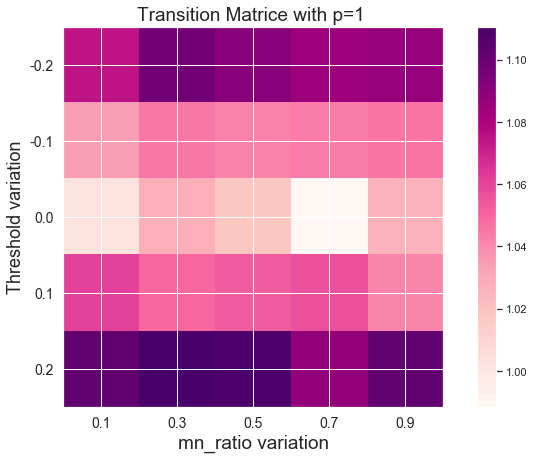

In [62]:
# Plotting phase transition matrice as images using p=1
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(pt_matrix_1norm, interpolation='nearest', cmap=plt.cm.RdPu)
plt.colorbar()
ax.set_title('Transition Matrice with p=1 ', fontsize=19)
ax.set_xlabel('mn_ratio variation', fontsize=19)
ax.set_ylabel('Threshold variation', fontsize=18)
plt.yticks(range(len(thresholds)), thresholds, fontsize=14)
plt.xticks(range(len(mn_ratios)), mn_ratios, fontsize=14)
plt.show()

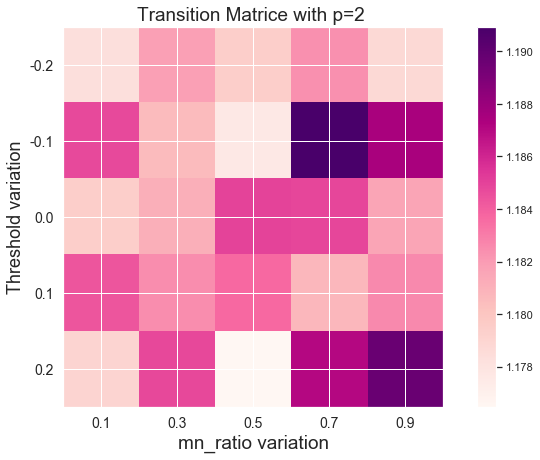

In [63]:
# Plotting phase transition matrices as images using p=2
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(pt_matrix_2norm, interpolation='nearest', cmap=plt.cm.RdPu)
plt.colorbar()
ax.set_title('Transition Matrice with p=2 ', fontsize=19)
ax.set_xlabel('mn_ratio variation', fontsize=19)
ax.set_ylabel('Threshold variation', fontsize=18)
plt.yticks(range(len(thresholds)), thresholds, fontsize=14)
plt.xticks(range(len(mn_ratios)), mn_ratios, fontsize=14)
plt.show()

### Question 18

Do the phase transition plots above provide any justification for choosing one $p-$norm interpolation over the other? Why?

**Answer:**

The p=1-norm interpolation looks like a better choice. In general, we can see that the relative error is lower with p=1 than with p=2. Also, we can see that the variation of the relative error is more predictable and symmetrical with p=1 in terms of thresholds, which allows for more controlled estimations. The results also do not vary too much for different mn ratios compared to p=2, which means that we can get similar accuracy with different numbers of initially known nodes.